### Imports

In this project, we plan to use optical character recognition (OCR) to read the values on water meters. We were given a set of photos of the meters with their values, and must train a computer vision model to detect the value, and be able to recognize the values. In this notebook, we are reviewing the data that we are given, so we may have an understanding of how to proceed.

In [476]:
import math, cv2, json, pandas as pd

import os, os.path

import img_preprocessing_functions as ipf

import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

### Loading

In [477]:
image_data = pd.read_csv("OCR-water-meters\TlkWaterMeters\data.tsv", sep="\t")
image_data.location = image_data.location.str.replace("\'", "\"")

In [478]:
image_data.head(3)

photo_name    value  \
0  id_53_value_595_825.jpg  595.825   
1  id_553_value_65_475.jpg   65.475   
2   id_407_value_21_86.jpg   21.860   

                                            location  
0  {"type": "polygon", "data": [{"x": 0.30788, "y...  
1  {"type": "polygon", "data": [{"x": 0.26133, "y...  
2  {"type": "polygon", "data": [{"x": 0.27545, "y...

### Feature Engineering

These will be the pandas `apply` functions to grab information from the tsv file we were provided with.

In [479]:
def num_coords(row):
    '''
    
    '''
    coords = json.loads(row['location'])
    return len(coords['data'])

In [480]:
def loc_to_pixel(row):
    '''
    
    '''
    coords = json.loads(row['location'])
    pixel_coords = []
    for coord in coords['data']:
        new_coord = {'x' : int(float(coord['x']) * row['width']), 
                     'y' : int(float(coord['y']) * row['height'])}
        pixel_coords.append(new_coord)

    return pixel_coords

In [481]:
def get_img_size(row):
    '''
    
    '''
    im = Image.open("OCR-water-meters\TlkWaterMeters\collage\\" + row)
    return im.size

In [482]:
def get_scaled_coords(row):
    '''

    '''
    coords = json.loads(row['location'])

    return coords['data']

In [483]:
image_data['num_coords'] = image_data.apply(num_coords, axis=1)

In [484]:
image_data['img_size'] = image_data.photo_name.apply(get_img_size)
image_data[['width', 'height']] = pd.DataFrame(image_data['img_size'].tolist(), index=image_data.index)

We will want the mask coordinates as pixel locations later on, so let's use the resolution of the images and the absolute coordinates from the json information.

In [485]:
image_data['pixel_coords'] = image_data.apply(loc_to_pixel, axis=1)

We do not need the json information about the mask being a polygon every time. Let's just extract the coordinates.

In [486]:
image_data['location'] = image_data.apply(get_scaled_coords, axis=1)

### EDA

In [487]:
num_images = len(image_data)
folders = ['images', 'collage', 'masks']

for folder in folders:
    DIR = "OCR-water-meters\TlkWaterMeters\\" + folder
    num_files = (len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))
    if num_images == num_files:
        print(folder, "folder has all", str(num_images), "meters accounted for.")


images folder has all 1244 meters accounted for.
collage folder has all 1244 meters accounted for.
masks folder has all 1244 meters accounted for.


It looks like there is no missing data.  

Let's take a look at the first three photos in each folder to see what images we are working with.

<Figure size 432x288 with 0 Axes>

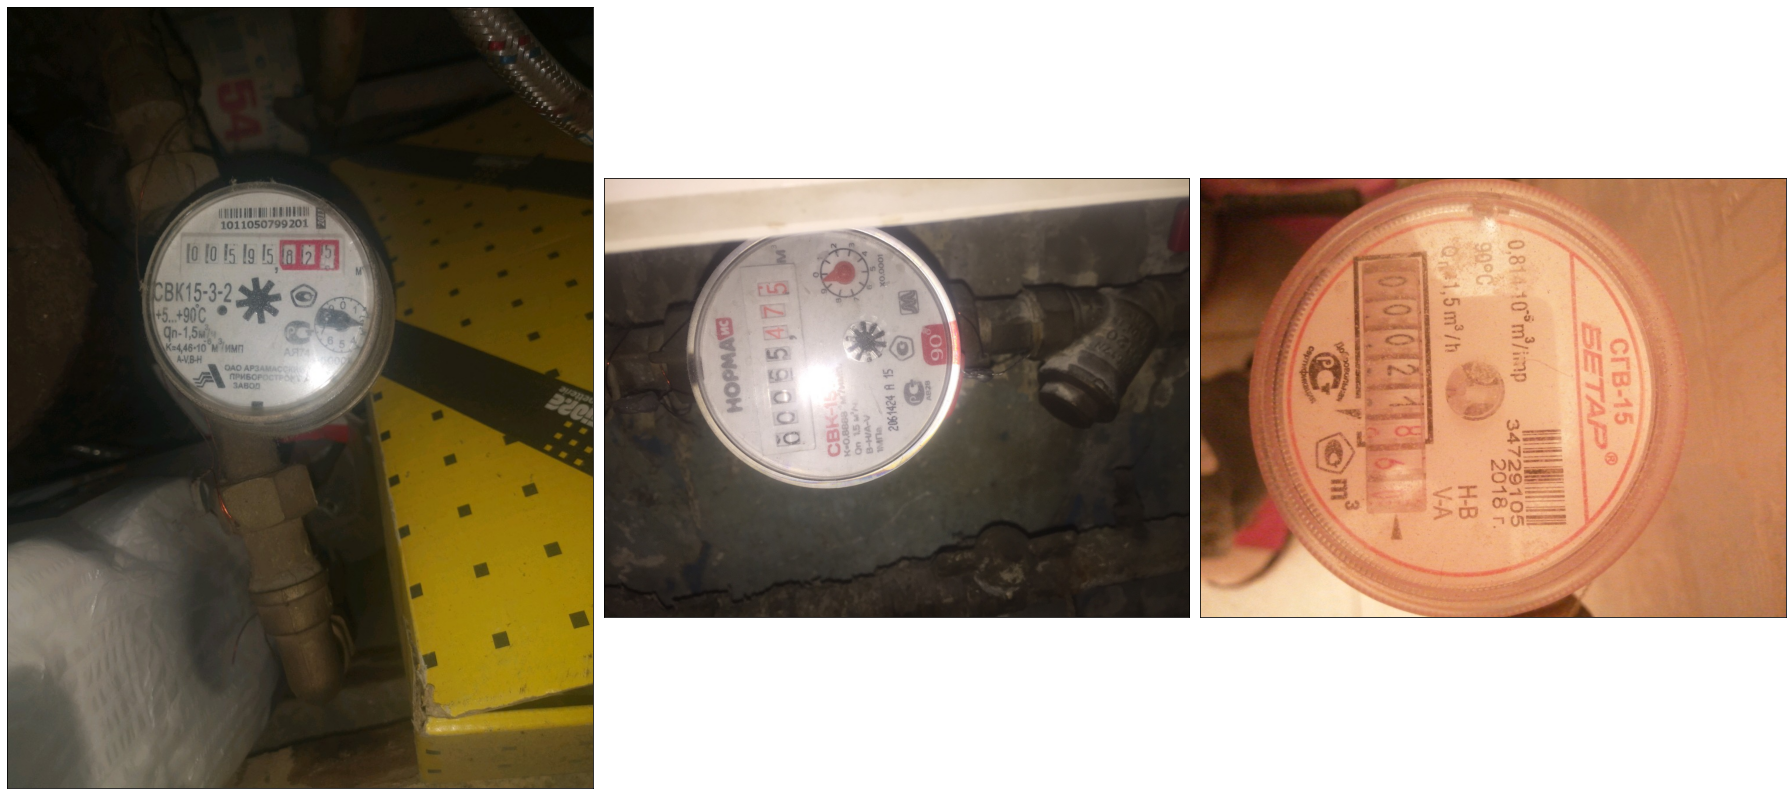

<Figure size 432x288 with 0 Axes>

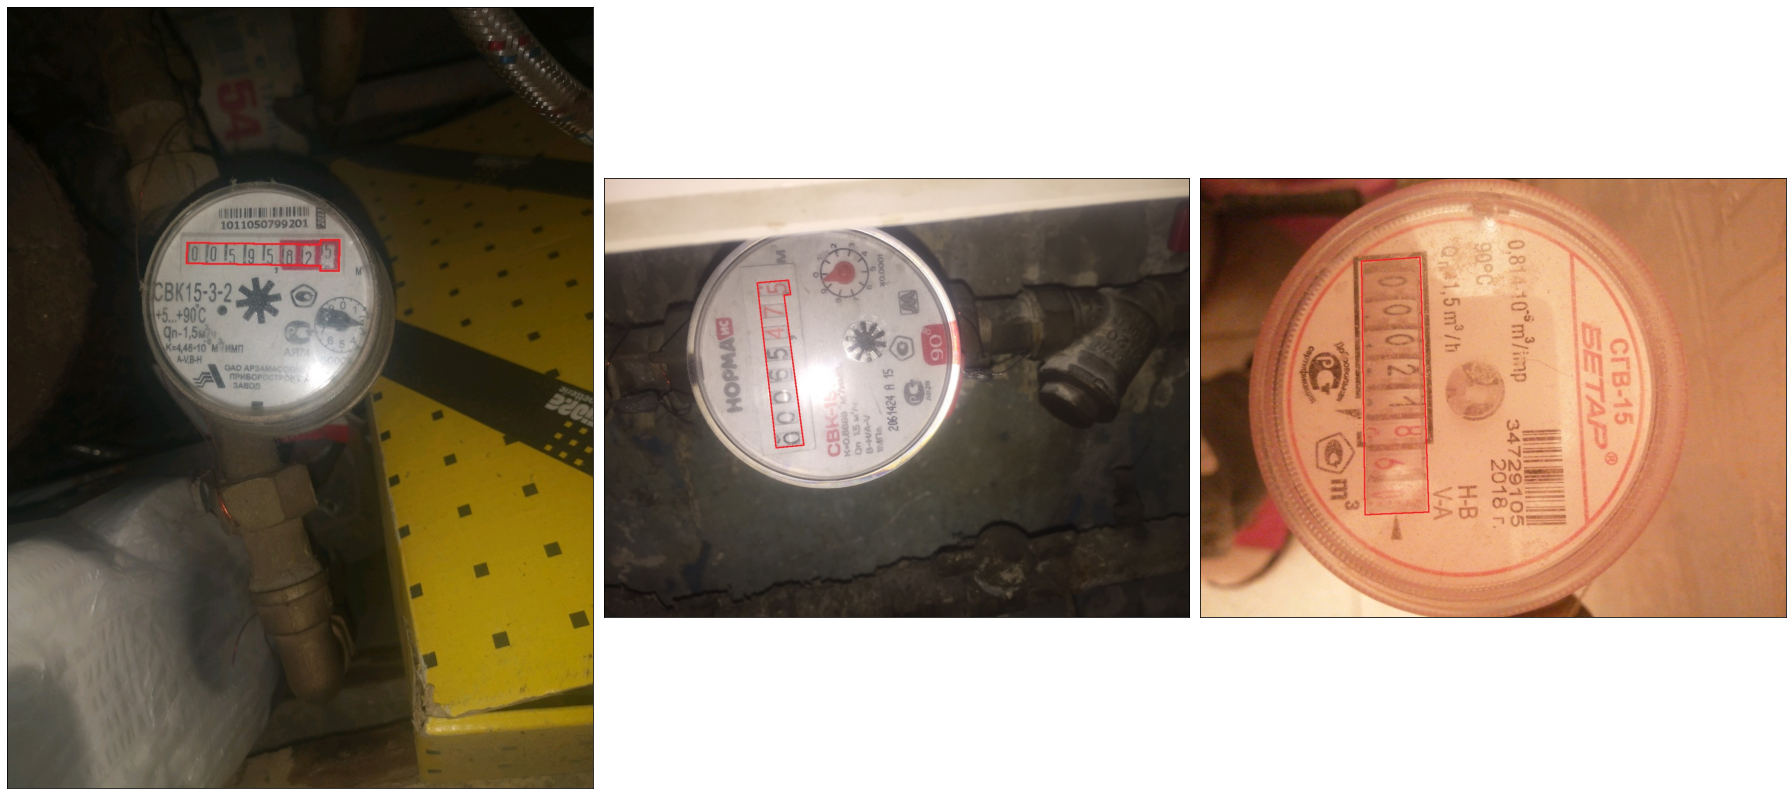

<Figure size 432x288 with 0 Axes>

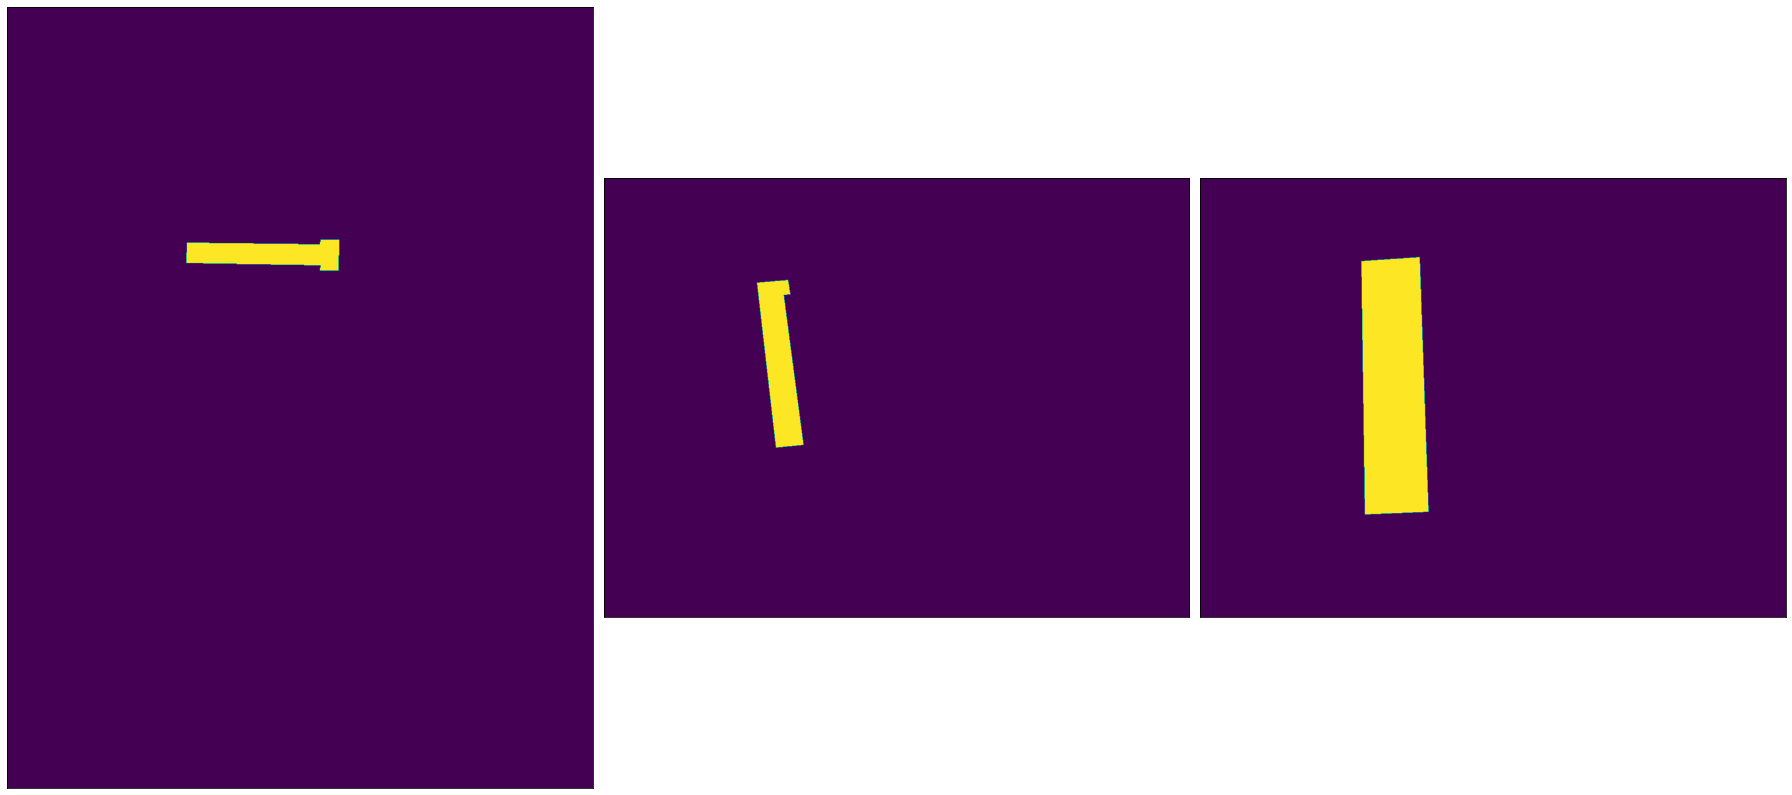

In [488]:
for folder in folders:
    plt.figure()
    f, ax = plt.subplots(1,3)
    for i in range(3):
        image_id = image_data.photo_name[i]
        path = "OCR-water-meters\TlkWaterMeters\\" + folder + "\\"+ image_id
        pic = plt.imread(path)
        ax[i].imshow(pic)
        ax[i].tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            left=False,
            right=False,
            labelbottom=False,
            labelleft=False,
            labeltop=False,
            )
    plt.gcf().set_size_inches(25, 15)
    plt.tight_layout()

The images folder is just the picture taken of the meter itself. There is a mask folder of a binary color mask showing our region of interest that was manually drawn. The collage is an empty polygon of the mask placed on the picture.

Now, let's begin looking into our numerical information.

In [489]:
def counts_graph(df, title='Title', xlabel='xlabel', ylabel='ylabel'):

    try:
        int(df.index[0])
        df = df.sort_index()
    except:
        pass
    
    fig = df.plot.bar(df)
    
    plt.gca().set_title(title)
    plt.gca().set_xlabel(xlabel)
    plt.gca().set_ylabel(ylabel)
    plt.gcf().set_size_inches(16, 8)
    plt.show()

In [490]:
num_coords_graph = image_data['num_coords'].value_counts()
num_coords_graph

6    508
4    505
8    231
Name: num_coords, dtype: int64

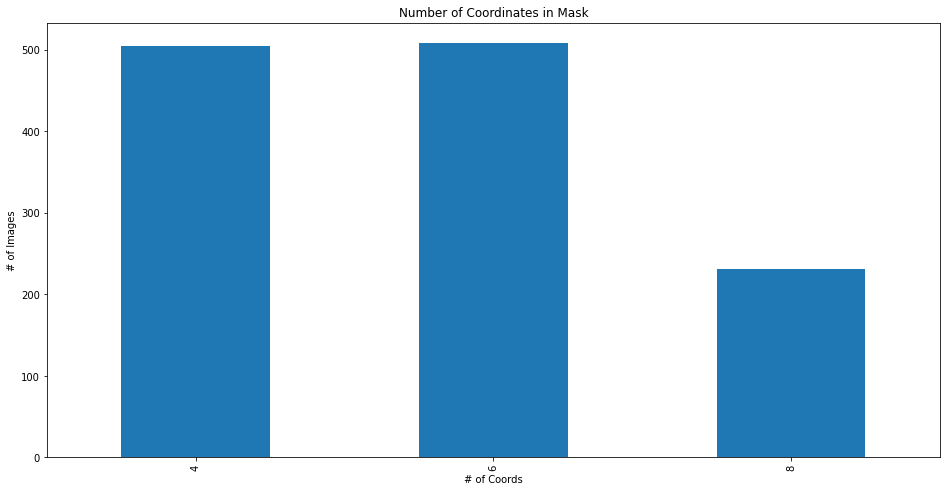

In [491]:
counts_graph(num_coords_graph, 'Number of Coordinates in Mask', '# of Coords', '# of Images')

A majority of the meters seem to have 4 or 6 coordinates, while a still significant number has 8 coordinates. From the images in the collage folder, it appears that the 6 and 8 coordinate masks are present when the final digit of the meter is a bit wider, as it typically moves the fastest, and may sometimes be rotated to be inbetween two digits. This is good to know as this may help future rotation, because this digit should always be the rightmost digit when the meter is viewed right-side up.

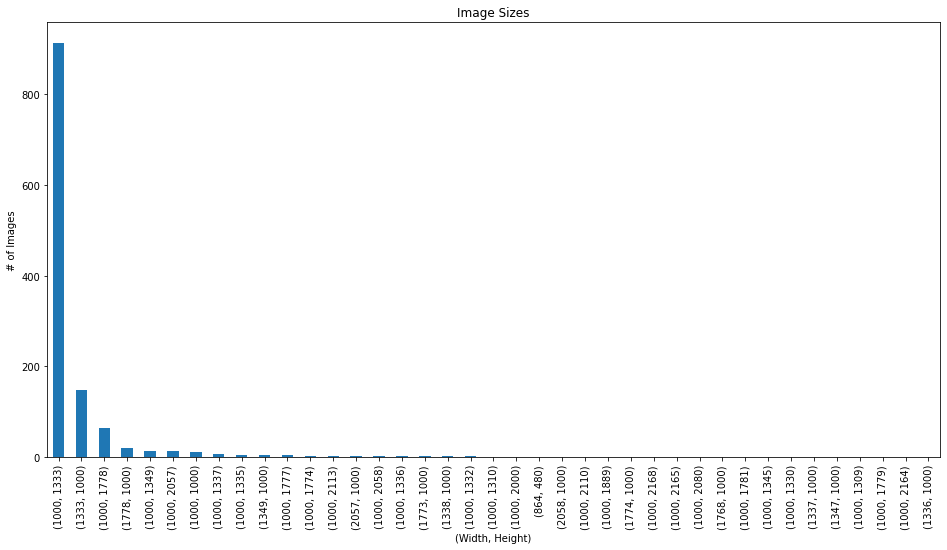

In [492]:
img_sizes = image_data['img_size'].value_counts()
counts_graph(img_sizes, 'Image Sizes', '(Width, Height)', '# of Images')

A significant majority of the images are either 1333x1000 or 1000x1333. As we can see from the images above, some are portrait and landscape, but the meter read-outs are not exclusive to a certain image orientation. As such, these can be considered the same category of images. After those photos, there are a few with different aspect ratios, but there are also a few outliers with odd pixel resolutions. These may be occuring due to cropping done prior to receiving the data, or inconsistent types of cameras that were used.

<Figure size 432x288 with 0 Axes>

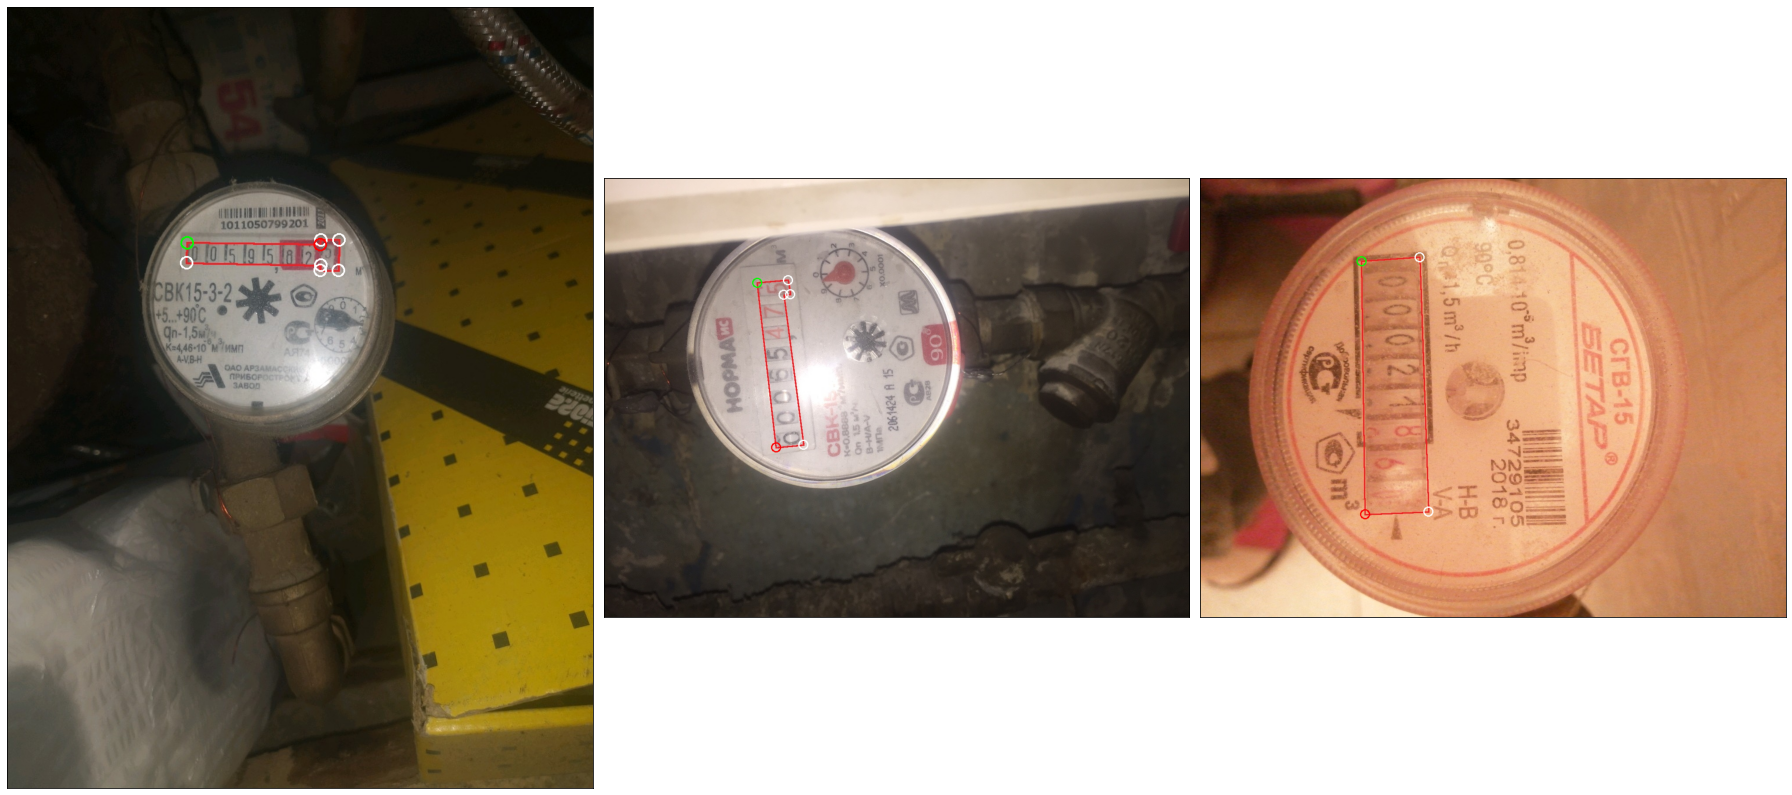

In [493]:
plt.figure()
f, ax = plt.subplots(1,3)
for i in range(3):
    image_id = image_data.photo_name[i]
    path = r"OCR-water-meters\TlkWaterMeters\collage\\" + image_id
    pic = plt.imread(path)
    green = 0
    for ii in range(image_data.num_coords[i]):
        x = list(image_data.pixel_coords[i][ii].values())[0]
        y = list(image_data.pixel_coords[i][ii].values())[1]
        center_coordinates = (x, y)
        radius = 10
        color = (255, 255, 255)
        if ii == 0:
            color = (0, 255, 0)
        if ii == int(image_data.num_coords[i]) - 1:
            color = (255, 0, 0)
        green += 255 // int(image_data.num_coords[i])
        thickness = 2
        pic = cv2.circle(pic, center_coordinates, radius, color, thickness)
    ax[i].imshow(pic)
    ax[i].tick_params(
        axis='both',                                                            # changes apply to both axes
        which='both',                                                           # both major and minor ticks are affected
        bottom=False, top=False, left=False, right=False,                       # remove ticks
        labelbottom=False, labeltop=False, labelleft=False, labelright=False    # remove labels
    )
plt.gcf().set_size_inches(25, 15)
plt.tight_layout()

It appears that the mask coordinates were not all created either clockwise or counter clockwise. The green circle is the first coordinate in the list, and the red circle is the last. We can see that the first image is done in CCW, and the second and third images are CW. 